In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

# === Step 1: Load and preprocess data ===
df = pd.read_csv("MAINDiagnostics.csv")
df = df.drop(columns=["IDFILENAME", "FileName", "Beat"])
df["Gender"] = df["Gender"].map({"MALE": 1, "FEMALE": 0})

normal_group = ["SR", "SB", "ST", "SI", "SAAWR"]
arrhythmia_group = ["AFIB", "AF", "SVT", "AT", "AVNRT", "AVRT"]
df["Rhythm_Binary"] = df["Rhythm"].apply(lambda x: 0 if x in normal_group else (1 if x in arrhythmia_group else np.nan))
df = df.dropna(subset=["Rhythm_Binary"])

X = df.drop(columns=["Rhythm", "Rhythm_Binary"], errors='ignore').values
y = df["Rhythm_Binary"].astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === SSO-inspired oversampling for class 1 ===
X_min = X_scaled[y == 1]
X_maj = X_scaled[y == 0]
n_to_generate = len(X_maj) - len(X_min)

def sso_augment(X, n_samples):
    n_features = X.shape[1]
    augmented = []
    for _ in range(n_samples):
        i, j = np.random.choice(len(X), 2, replace=False)
        alpha = np.random.uniform(-1, 1, n_features)
        sample = X[i] + alpha * (X[j] - X[i])
        augmented.append(sample)
    return np.array(augmented)

X_syn = sso_augment(X_min, n_to_generate)
y_syn = np.ones(n_to_generate, dtype=int)

X_bal = np.vstack([X_scaled, X_syn])
y_bal = np.concatenate([y, y_syn])

# === Train/test split ===
X_train, X_val, y_train, y_val = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)
input_dim = X_train.shape[1]

# === Step 2: Define fuzzy membership layer ===
class FuzzyLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, num_memberships):
        super(FuzzyLayer, self).__init__()
        self.in_features = in_features
        self.num_memberships = num_memberships
        self.mu = self.add_weight("mu", shape=[num_memberships, in_features], initializer="random_normal", trainable=True)
        self.sigma = self.add_weight("sigma", shape=[num_memberships, in_features], initializer="ones", trainable=True)

    def call(self, inputs):
        x = tf.expand_dims(inputs, axis=1)
        mu = tf.expand_dims(self.mu, axis=0)
        sigma = tf.expand_dims(self.sigma, axis=0)
        return tf.exp(-tf.square((x - mu) / sigma))

# === Step 3: Build model ===
def build_model(mu_init, sigma_init):
    fuzzy = FuzzyLayer(input_dim, num_memberships=3)
    fuzzy.mu.assign(tf.convert_to_tensor(mu_init, dtype=tf.float32))
    fuzzy.sigma.assign(tf.convert_to_tensor(sigma_init, dtype=tf.float32))
    
    inputs = tf.keras.Input(shape=(input_dim,))
    fuzzy_out = fuzzy(inputs)
    flat = tf.keras.layers.Flatten()(fuzzy_out)
    dense1 = tf.keras.layers.Dense(128, activation='relu')(flat)
    drop = tf.keras.layers.Dropout(0.2)(dense1)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(drop)
    output = tf.keras.layers.Dense(2, activation='softmax')(dense2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# === Step 4: WHHO optimization ===
def fitness_function(position):
    mu = position[:len(position)//2].reshape(3, input_dim)
    sigma = np.abs(position[len(position)//2:].reshape(3, input_dim)) + 1e-2
    model = build_model(mu, sigma)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = np.argmax(model.predict(X_val), axis=1)
    return 1 - accuracy_score(y_val, y_pred)

def whho_optimize(dim, n_agents=5, max_iter=5):
    pop = np.random.uniform(-1, 1, (n_agents, dim))
    fitness = np.array([fitness_function(ind) for ind in pop])
    best_idx = np.argmin(fitness)
    best = pop[best_idx]

    for _ in range(max_iter):
        for i in range(n_agents):
            r = np.random.rand()
            pop[i] = pop[i] + r * (best - pop[i])
            fitness[i] = fitness_function(pop[i])
        best_idx = np.argmin(fitness)
        best = pop[best_idx]
    return best

dim = 2 * 3 * input_dim
opt_vector = whho_optimize(dim)
mu_opt = opt_vector[:len(opt_vector)//2].reshape(3, input_dim)
sigma_opt = np.abs(opt_vector[len(opt_vector)//2:].reshape(3, input_dim)) + 1e-2

# === Step 5: Train final model ===
final_model = build_model(mu_opt, sigma_opt)
final_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1)

# === Step 6: Evaluate ===
y_pred_final = np.argmax(final_model.predict(X_val), axis=1)
print(classification_report(y_val, y_pred_final, target_names=["Normal", "Arrhythmia"]))


92/92 [==============================] - 0s 602us/step
Epoch 1/30
365/365 [==============================] - 1s 1ms/step - loss: 0.4158 - accuracy: 0.8075 - val_loss: 0.3090 - val_accuracy: 0.8680
Epoch 2/30
365/365 [==============================] - 0s 1ms/step - loss: 0.2724 - accuracy: 0.8903 - val_loss: 0.2465 - val_accuracy: 0.8978
Epoch 3/30
365/365 [==============================] - 0s 983us/step - loss: 0.2178 - accuracy: 0.9179 - val_loss: 0.2031 - val_accuracy: 0.9228
Epoch 4/30
365/365 [==============================] - 0s 999us/step - loss: 0.1936 - accuracy: 0.9284 - val_loss: 0.1838 - val_accuracy: 0.9324
Epoch 5/30
365/365 [==============================] - 0s 994us/step - loss: 0.1757 - accuracy: 0.9382 - val_loss: 0.1822 - val_accuracy: 0.9338
Epoch 6/30
365/365 [==============================] - 0s 1ms/step - loss: 0.1619 - accuracy: 0.9401 - val_loss: 0.1685 - val_accuracy: 0.9403
Epoch 7/30
365/365 [==============================] - 0s 1ms/step - loss: 0.1514 - accu

4/4 [==============================] - 0s 664us/step


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

313/313 [==============================] - 0s 588us/step


  1%|▊                                                                                 | 1/100 [00:00<00:30,  3.29it/s]

313/313 [==============================] - 0s 631us/step


  2%|█▋                                                                                | 2/100 [00:00<00:30,  3.18it/s]

313/313 [==============================] - 0s 581us/step


  3%|██▍                                                                               | 3/100 [00:00<00:29,  3.24it/s]

313/313 [==============================] - 0s 601us/step


  4%|███▎                                                                              | 4/100 [00:01<00:29,  3.21it/s]

313/313 [==============================] - 0s 643us/step


  5%|████                                                                              | 5/100 [00:01<00:29,  3.17it/s]

313/313 [==============================] - 0s 597us/step


  6%|████▉                                                                             | 6/100 [00:01<00:29,  3.20it/s]

313/313 [==============================] - 0s 632us/step


  7%|█████▋                                                                            | 7/100 [00:02<00:29,  3.17it/s]

313/313 [==============================] - 0s 617us/step


  8%|██████▌                                                                           | 8/100 [00:02<00:28,  3.18it/s]

313/313 [==============================] - 0s 585us/step


  9%|███████▍                                                                          | 9/100 [00:02<00:28,  3.22it/s]

313/313 [==============================] - 0s 610us/step


 10%|████████                                                                         | 10/100 [00:03<00:27,  3.23it/s]

313/313 [==============================] - 0s 671us/step


 11%|████████▉                                                                        | 11/100 [00:03<00:28,  3.13it/s]

313/313 [==============================] - 0s 556us/step


 12%|█████████▋                                                                       | 12/100 [00:03<00:27,  3.24it/s]

313/313 [==============================] - 0s 556us/step


 13%|██████████▌                                                                      | 13/100 [00:04<00:26,  3.31it/s]

313/313 [==============================] - 0s 553us/step


 14%|███████████▎                                                                     | 14/100 [00:04<00:25,  3.38it/s]

313/313 [==============================] - 0s 568us/step


 15%|████████████▏                                                                    | 15/100 [00:04<00:26,  3.26it/s]

313/313 [==============================] - 0s 575us/step


 16%|████████████▉                                                                    | 16/100 [00:04<00:25,  3.31it/s]

313/313 [==============================] - 0s 578us/step


 17%|█████████████▊                                                                   | 17/100 [00:05<00:24,  3.34it/s]

313/313 [==============================] - 0s 565us/step


 18%|██████████████▌                                                                  | 18/100 [00:05<00:24,  3.38it/s]

313/313 [==============================] - 0s 565us/step


 19%|███████████████▍                                                                 | 19/100 [00:05<00:23,  3.41it/s]

313/313 [==============================] - 0s 559us/step


 20%|████████████████▏                                                                | 20/100 [00:06<00:23,  3.43it/s]

313/313 [==============================] - 0s 572us/step


 21%|█████████████████                                                                | 21/100 [00:06<00:23,  3.43it/s]

313/313 [==============================] - 0s 559us/step


 22%|█████████████████▊                                                               | 22/100 [00:06<00:22,  3.46it/s]

313/313 [==============================] - 0s 569us/step


 23%|██████████████████▋                                                              | 23/100 [00:06<00:22,  3.45it/s]

313/313 [==============================] - 0s 559us/step


 24%|███████████████████▍                                                             | 24/100 [00:07<00:22,  3.41it/s]

313/313 [==============================] - 0s 559us/step


 25%|████████████████████▎                                                            | 25/100 [00:07<00:22,  3.39it/s]

313/313 [==============================] - 0s 546us/step


 26%|█████████████████████                                                            | 26/100 [00:07<00:21,  3.41it/s]

313/313 [==============================] - 0s 578us/step


 27%|█████████████████████▊                                                           | 27/100 [00:08<00:21,  3.42it/s]

313/313 [==============================] - 0s 594us/step


 28%|██████████████████████▋                                                          | 28/100 [00:08<00:21,  3.39it/s]

313/313 [==============================] - 0s 559us/step


 29%|███████████████████████▍                                                         | 29/100 [00:08<00:20,  3.40it/s]

313/313 [==============================] - 0s 546us/step


 30%|████████████████████████▎                                                        | 30/100 [00:09<00:20,  3.43it/s]

313/313 [==============================] - 0s 559us/step


 31%|█████████████████████████                                                        | 31/100 [00:09<00:19,  3.46it/s]

313/313 [==============================] - 0s 559us/step


 32%|█████████████████████████▉                                                       | 32/100 [00:09<00:19,  3.47it/s]

313/313 [==============================] - 0s 559us/step


 33%|██████████████████████████▋                                                      | 33/100 [00:09<00:19,  3.48it/s]

313/313 [==============================] - 0s 575us/step


 34%|███████████████████████████▌                                                     | 34/100 [00:10<00:19,  3.47it/s]

313/313 [==============================] - 0s 549us/step


 35%|████████████████████████████▎                                                    | 35/100 [00:10<00:18,  3.50it/s]

313/313 [==============================] - 0s 543us/step


 36%|█████████████████████████████▏                                                   | 36/100 [00:10<00:18,  3.52it/s]

313/313 [==============================] - 0s 559us/step


 37%|█████████████████████████████▉                                                   | 37/100 [00:11<00:17,  3.50it/s]

313/313 [==============================] - 0s 546us/step


 38%|██████████████████████████████▊                                                  | 38/100 [00:11<00:17,  3.52it/s]

313/313 [==============================] - 0s 604us/step


 39%|███████████████████████████████▌                                                 | 39/100 [00:11<00:17,  3.46it/s]

313/313 [==============================] - 0s 604us/step


 40%|████████████████████████████████▍                                                | 40/100 [00:11<00:17,  3.39it/s]

313/313 [==============================] - 0s 578us/step


 41%|█████████████████████████████████▏                                               | 41/100 [00:12<00:17,  3.39it/s]

313/313 [==============================] - 0s 569us/step


 42%|██████████████████████████████████                                               | 42/100 [00:12<00:17,  3.41it/s]

313/313 [==============================] - 0s 549us/step


 43%|██████████████████████████████████▊                                              | 43/100 [00:12<00:16,  3.44it/s]

313/313 [==============================] - 0s 562us/step


 44%|███████████████████████████████████▋                                             | 44/100 [00:13<00:16,  3.46it/s]

313/313 [==============================] - 0s 591us/step


 45%|████████████████████████████████████▍                                            | 45/100 [00:13<00:16,  3.41it/s]

313/313 [==============================] - 0s 565us/step


 46%|█████████████████████████████████████▎                                           | 46/100 [00:13<00:15,  3.42it/s]

313/313 [==============================] - 0s 549us/step


 47%|██████████████████████████████████████                                           | 47/100 [00:13<00:15,  3.45it/s]

313/313 [==============================] - 0s 559us/step


 48%|██████████████████████████████████████▉                                          | 48/100 [00:14<00:15,  3.46it/s]

313/313 [==============================] - 0s 722us/step


 49%|███████████████████████████████████████▋                                         | 49/100 [00:14<00:15,  3.29it/s]

313/313 [==============================] - 0s 559us/step


 50%|████████████████████████████████████████▌                                        | 50/100 [00:14<00:14,  3.36it/s]

313/313 [==============================] - 0s 639us/step


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:15<00:14,  3.30it/s]

313/313 [==============================] - 0s 585us/step


 52%|██████████████████████████████████████████                                       | 52/100 [00:15<00:14,  3.33it/s]

313/313 [==============================] - 0s 594us/step


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:15<00:14,  3.33it/s]

313/313 [==============================] - 0s 594us/step


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:16<00:13,  3.31it/s]

313/313 [==============================] - 0s 594us/step


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:16<00:13,  3.30it/s]

313/313 [==============================] - 0s 623us/step


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:16<00:13,  3.30it/s]

313/313 [==============================] - 0s 553us/step


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:16<00:12,  3.35it/s]

313/313 [==============================] - 0s 551us/step


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:17<00:12,  3.41it/s]

313/313 [==============================] - 0s 565us/step


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:17<00:11,  3.43it/s]

313/313 [==============================] - 0s 569us/step


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:17<00:11,  3.43it/s]

313/313 [==============================] - 0s 565us/step


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:18<00:11,  3.41it/s]

313/313 [==============================] - 0s 562us/step


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:18<00:11,  3.43it/s]

313/313 [==============================] - 0s 572us/step


 63%|███████████████████████████████████████████████████                              | 63/100 [00:18<00:10,  3.43it/s]

313/313 [==============================] - 0s 556us/step


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:18<00:10,  3.46it/s]

313/313 [==============================] - 0s 549us/step


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:19<00:10,  3.48it/s]

313/313 [==============================] - 0s 559us/step


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:19<00:09,  3.49it/s]

313/313 [==============================] - 0s 565us/step


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:19<00:09,  3.49it/s]

313/313 [==============================] - 0s 610us/step


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:20<00:09,  3.43it/s]

313/313 [==============================] - 0s 562us/step


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:20<00:09,  3.41it/s]

313/313 [==============================] - 0s 597us/step


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:20<00:08,  3.38it/s]

313/313 [==============================] - 0s 559us/step


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:21<00:08,  3.42it/s]

313/313 [==============================] - 0s 556us/step


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:21<00:08,  3.46it/s]

313/313 [==============================] - 0s 549us/step


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:21<00:07,  3.46it/s]

313/313 [==============================] - 0s 569us/step


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:21<00:07,  3.44it/s]

313/313 [==============================] - 0s 725us/step


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:22<00:07,  3.27it/s]

313/313 [==============================] - 0s 623us/step


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:22<00:07,  3.25it/s]

313/313 [==============================] - 0s 598us/step


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:22<00:07,  3.26it/s]

313/313 [==============================] - 0s 598us/step


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:23<00:06,  3.28it/s]

313/313 [==============================] - 0s 599us/step


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:23<00:06,  3.27it/s]

313/313 [==============================] - 0s 634us/step


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:23<00:06,  3.23it/s]

313/313 [==============================] - 0s 667us/step


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:24<00:06,  3.11it/s]

313/313 [==============================] - 0s 696us/step


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:24<00:05,  3.04it/s]

313/313 [==============================] - 0s 779us/step


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:24<00:05,  2.97it/s]

313/313 [==============================] - 0s 629us/step


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:25<00:05,  3.01it/s]

313/313 [==============================] - 0s 617us/step


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:25<00:04,  3.05it/s]

313/313 [==============================] - 0s 789us/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:25<00:04,  2.94it/s]

313/313 [==============================] - 0s 629us/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:26<00:04,  3.01it/s]

313/313 [==============================] - 0s 687us/step


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:26<00:03,  3.00it/s]

313/313 [==============================] - 0s 770us/step


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:26<00:03,  2.91it/s]

313/313 [==============================] - 0s 632us/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:27<00:03,  2.96it/s]

313/313 [==============================] - 0s 620us/step


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:27<00:02,  3.04it/s]

313/313 [==============================] - 0s 757us/step


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:27<00:02,  2.94it/s]

313/313 [==============================] - 0s 594us/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:28<00:02,  3.03it/s]

313/313 [==============================] - 0s 668us/step


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:28<00:01,  3.05it/s]

313/313 [==============================] - 0s 732us/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:28<00:01,  3.01it/s]

313/313 [==============================] - 0s 655us/step


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:29<00:01,  3.00it/s]

313/313 [==============================] - 0s 591us/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:29<00:00,  3.07it/s]

313/313 [==============================] - 0s 827us/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:29<00:00,  2.92it/s]

313/313 [==============================] - 0s 668us/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:30<00:00,  2.95it/s]

313/313 [==============================] - 0s 578us/step


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.28it/s]
C:\Users\Arman\AppData\Local\Temp\ipykernel_2168\784972350.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


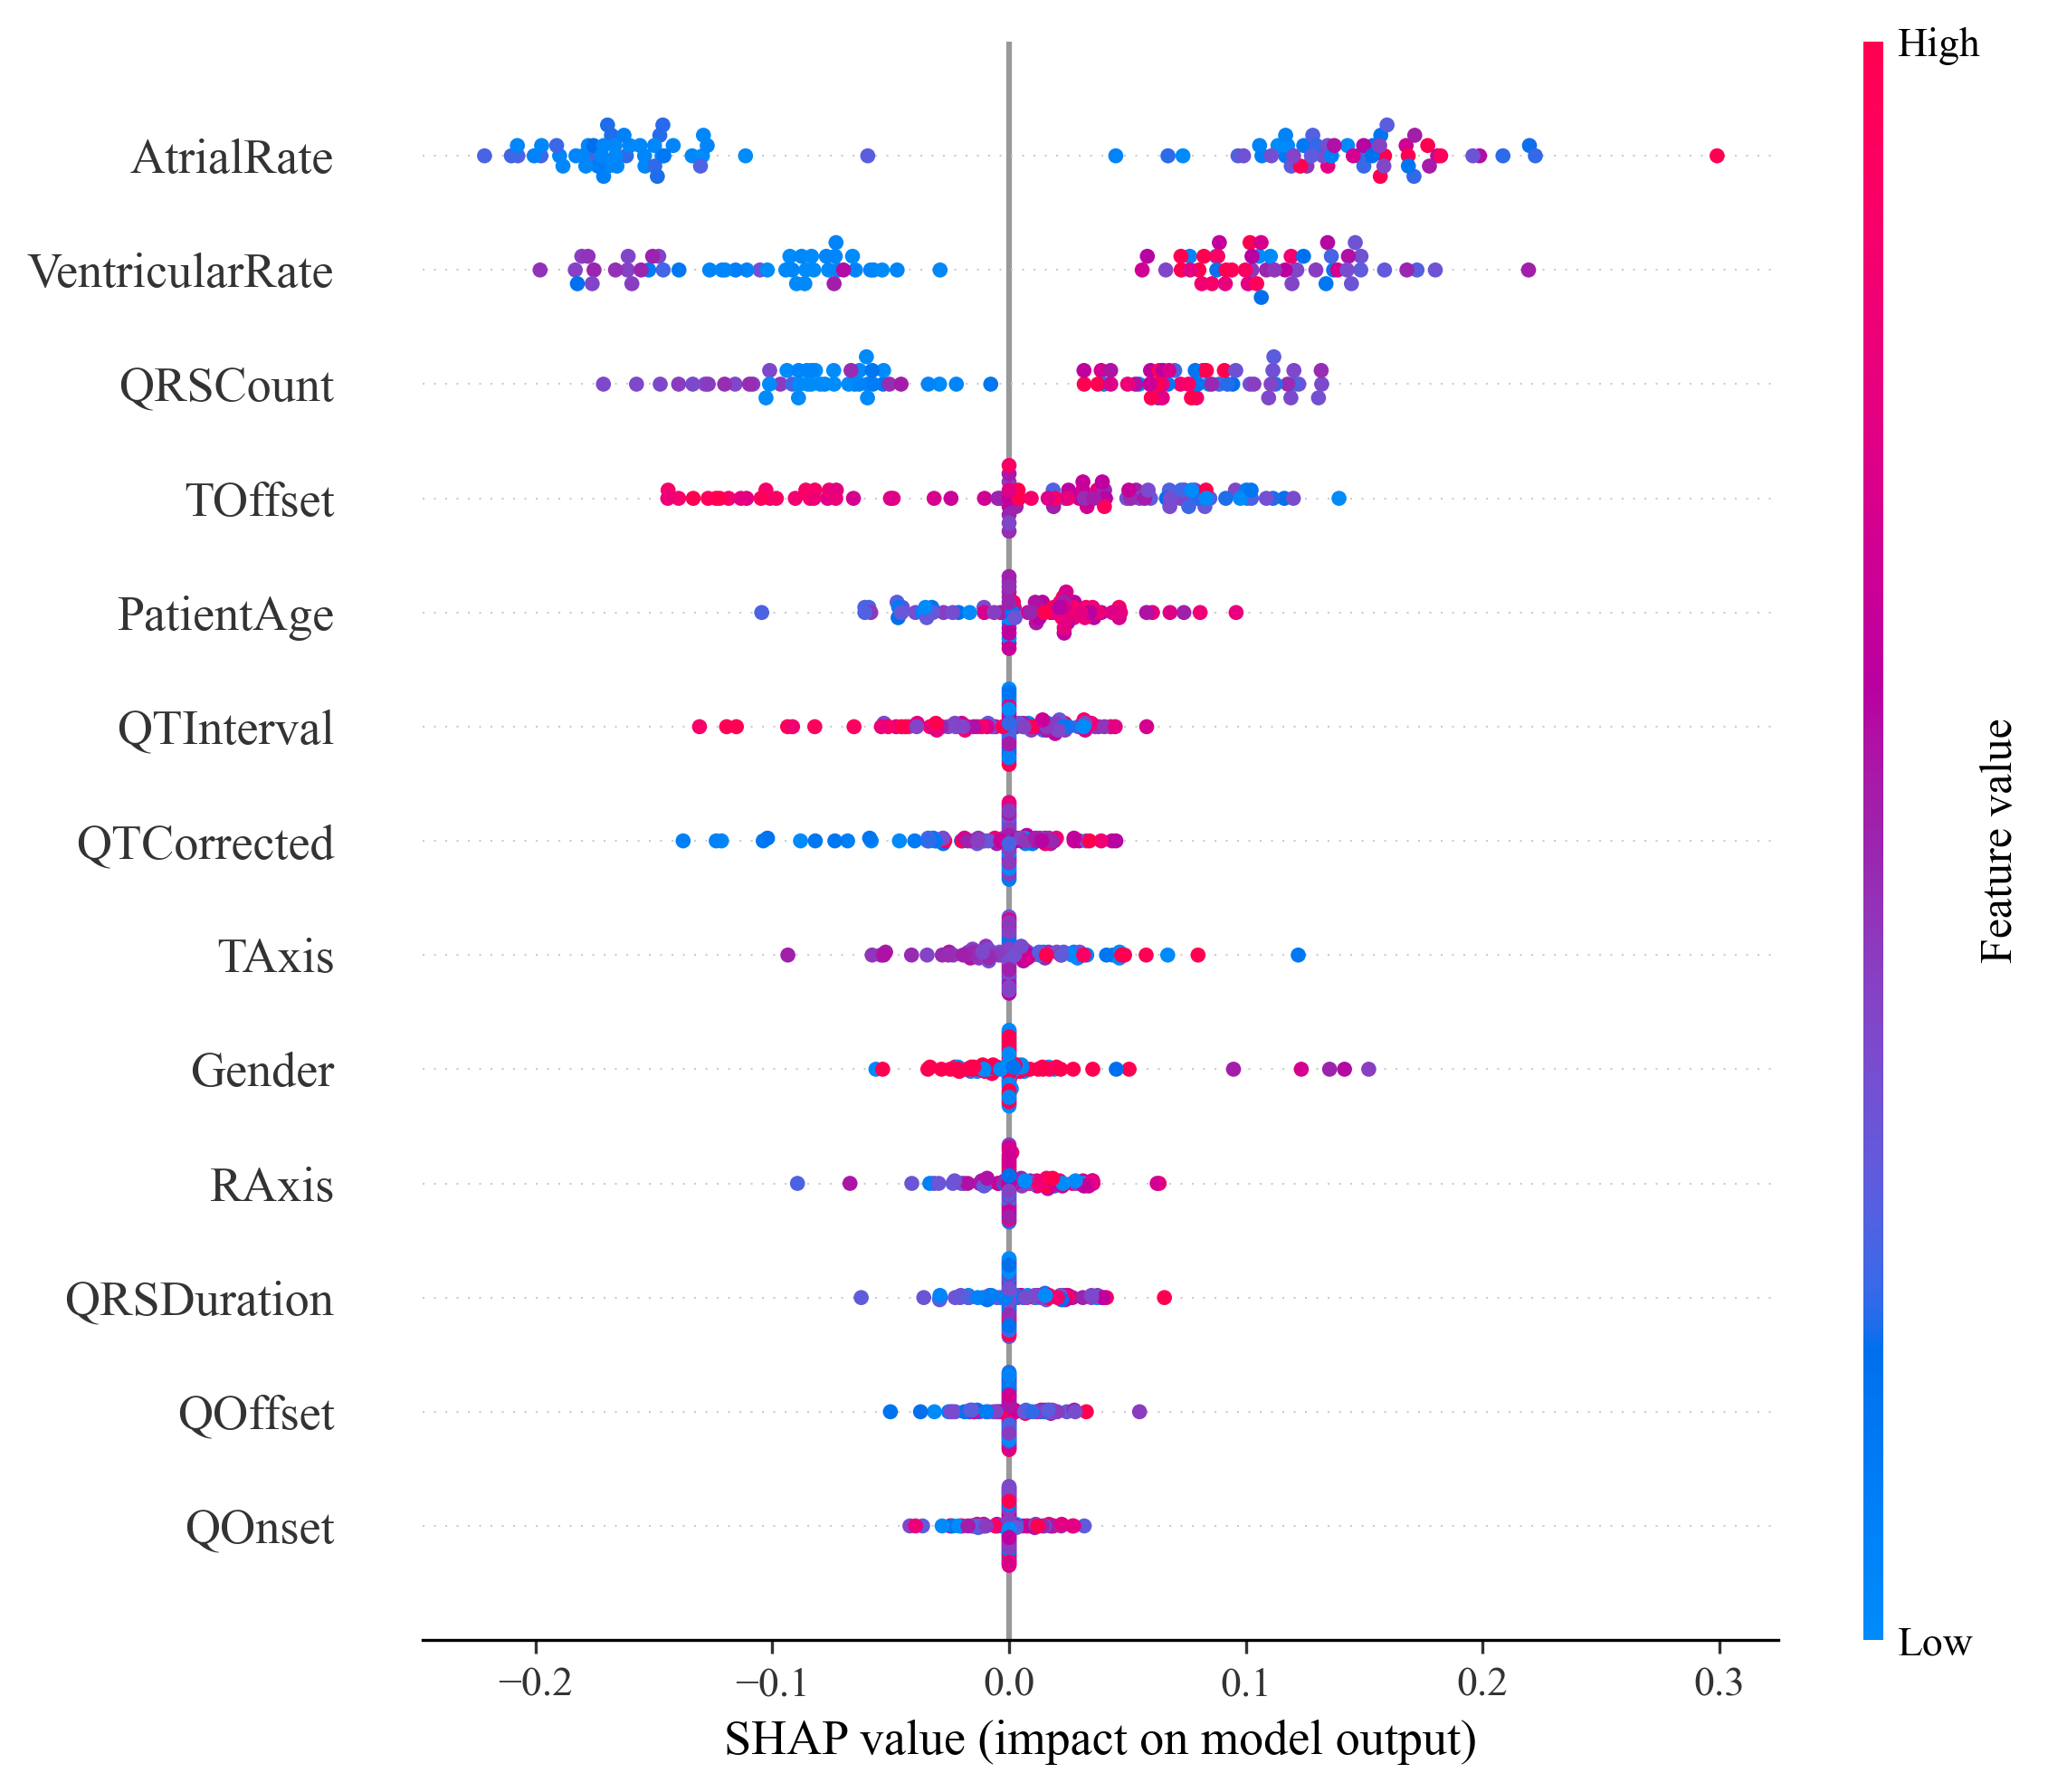

In [16]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Set font globally to Times New Roman
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Define class 1 probability prediction
def predict_class1(X):
    preds = final_model.predict(X)
    return preds[:, 1]

# Select background and explanation samples
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
X_val_sample = X_val[:100]

# Create SHAP explainer
explainer = shap.KernelExplainer(predict_class1, background)

# Compute SHAP values
shap_values = explainer.shap_values(X_val_sample, nsamples=100)

# Square plot settings
plt.figure(figsize=(8, 8), dpi=300)  # Square figure
shap.summary_plot(
    shap_values, 
    X_val_sample, 
    feature_names=df.drop(columns=["Rhythm", "Rhythm_Binary"]).columns.tolist(), 
    show=False
)
plt.tight_layout()
plt.savefig("ّfINAL_shap_summary_arrhythmia_square.png", dpi=300)
plt.show()


157/157 [==============================] - 0s 562us/step


<Figure size 2400x2400 with 0 Axes>

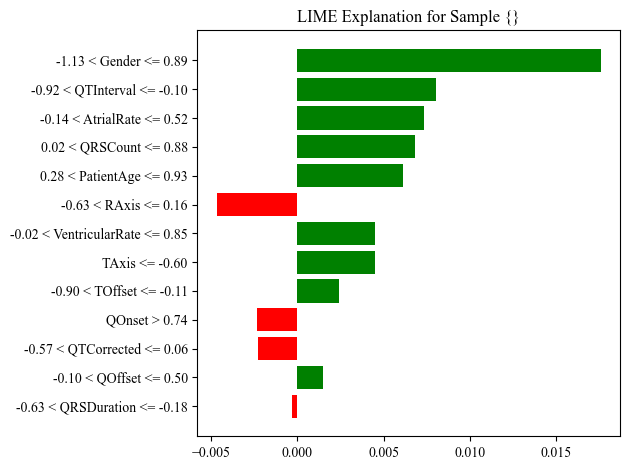

In [24]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Set font globally to Times New Roman
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Extract correct feature names from the dataframe
feature_names = df.drop(columns=["Rhythm", "Rhythm_Binary"]).columns.tolist()

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=["Normal", "Arrhythmia"],
    mode='classification',
    discretize_continuous=True
)

# Choose an index from the validation set to explain
i = 50  # You can change this index to explore other samples

# Generate LIME explanation for the selected instance
exp = explainer.explain_instance(
    X_val[i],
    final_model.predict,
    num_features=len(feature_names)
)

# Plot the LIME explanation in a square format
fig = plt.figure(figsize=(8, 8), dpi=300)
exp.as_pyplot_figure(label=1)  # Use label=0 or 1 depending on the class of interest
plt.title("LIME Explanation for Sample {}", fontsize=12, fontname='Times New Roman')
plt.tight_layout()
plt.savefig("lime_explanation_sample{}_square.png".format(i), dpi=300)
plt.show()


1/1 [==============================] - 0s 13ms/step


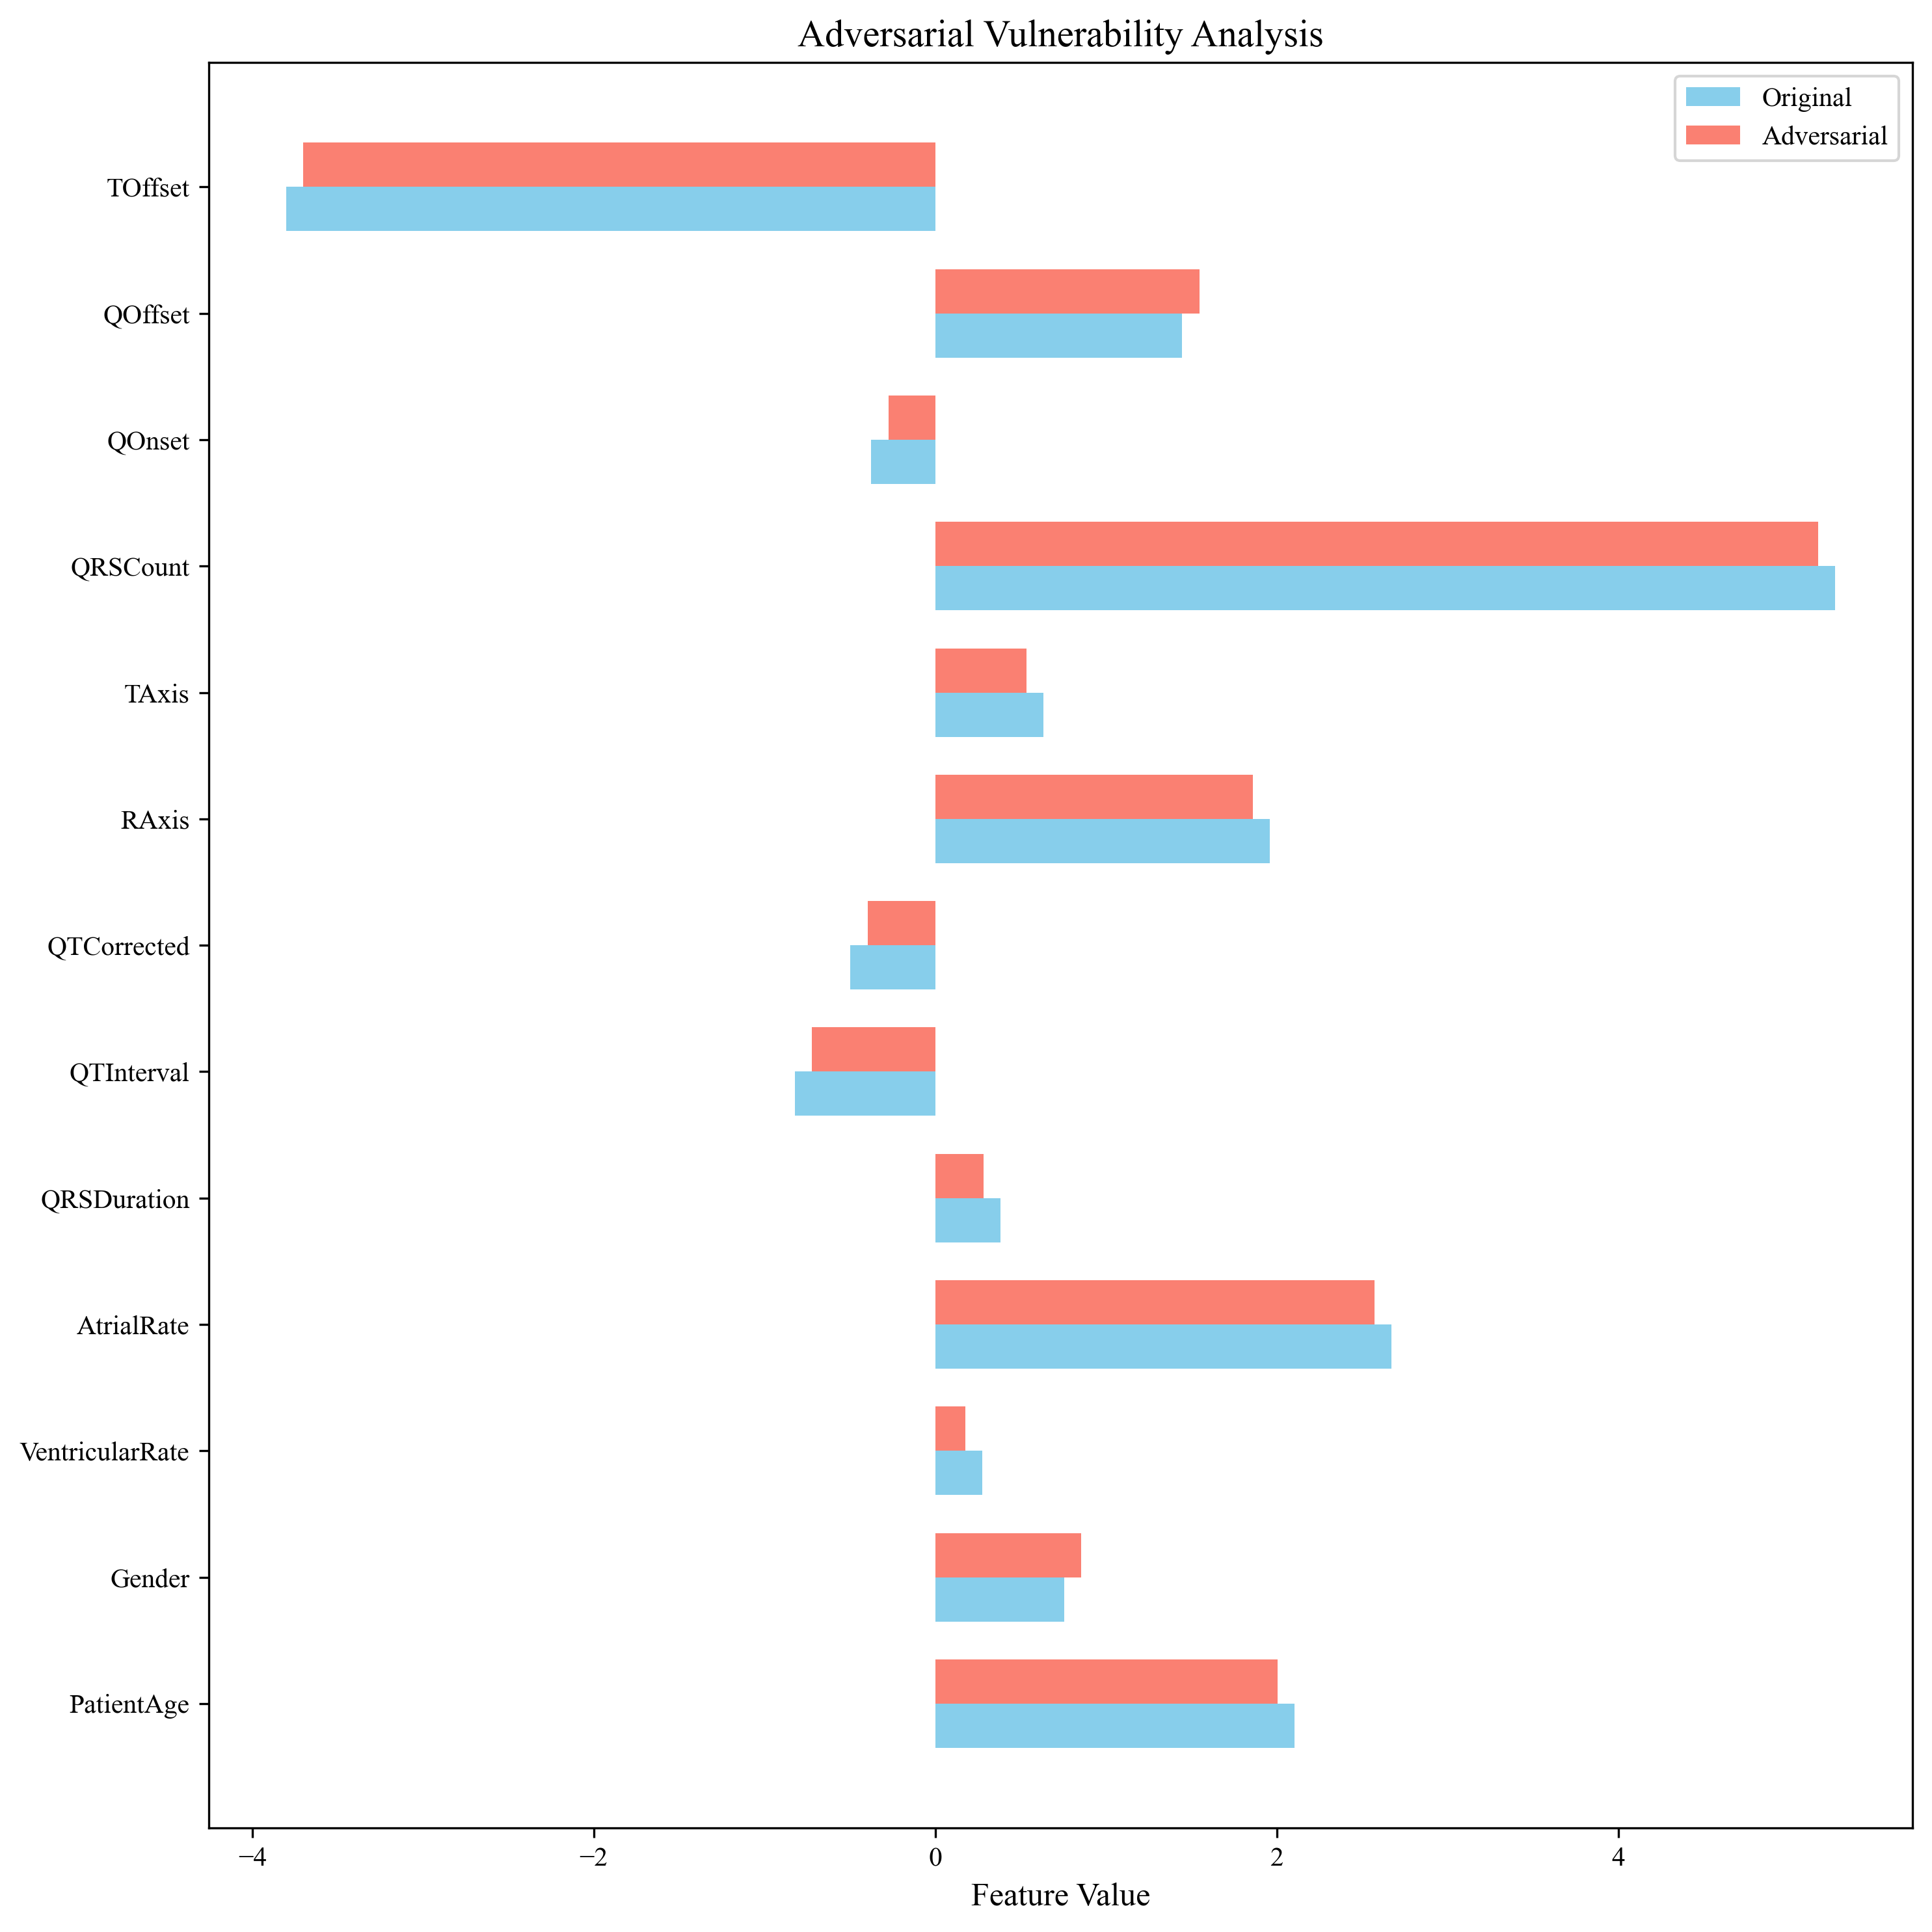

Original prediction: 1 -> Adversarial prediction: 1


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib

# Set font to Times New Roman
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Select a sample from validation set
x_sample = X_val[10:11]
y_true_label = y_val[10]

# Predict original class
original_pred = np.argmax(final_model.predict(x_sample), axis=1)[0]

# Compute gradient for FGSM
x_tensor = tf.convert_to_tensor(x_sample, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(x_tensor)
    prediction = final_model(x_tensor)
    loss = tf.keras.losses.sparse_categorical_crossentropy([y_true_label], prediction)
gradient = tape.gradient(loss, x_tensor).numpy()

# Apply FGSM
epsilon = 0.1
x_adv = x_sample + epsilon * np.sign(gradient)

# Predict on adversarial sample
adversarial_pred = np.argmax(final_model.predict(x_adv), axis=1)[0]

# Plot comparison
feature_names = df.drop(columns=["Rhythm", "Rhythm_Binary"]).columns.tolist()
x_original_flat = x_sample.flatten()
x_adv_flat = x_adv.flatten()

x_indices = np.arange(len(feature_names))
width = 0.35

plt.figure(figsize=(10, 10), dpi=300)
plt.barh(x_indices - width/2, x_original_flat, height=width, label='Original', color='skyblue')
plt.barh(x_indices + width/2, x_adv_flat, height=width, label='Adversarial', color='salmon')
plt.yticks(x_indices, feature_names, fontsize=10)
plt.xlabel('Feature Value', fontsize=12)
plt.title('Adversarial Vulnerability Analysis', fontsize=14)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("adversarial_vulnerability_sample10.png", dpi=300)
plt.show()

print(f"Original prediction: {original_pred} -> Adversarial prediction: {adversarial_pred}")


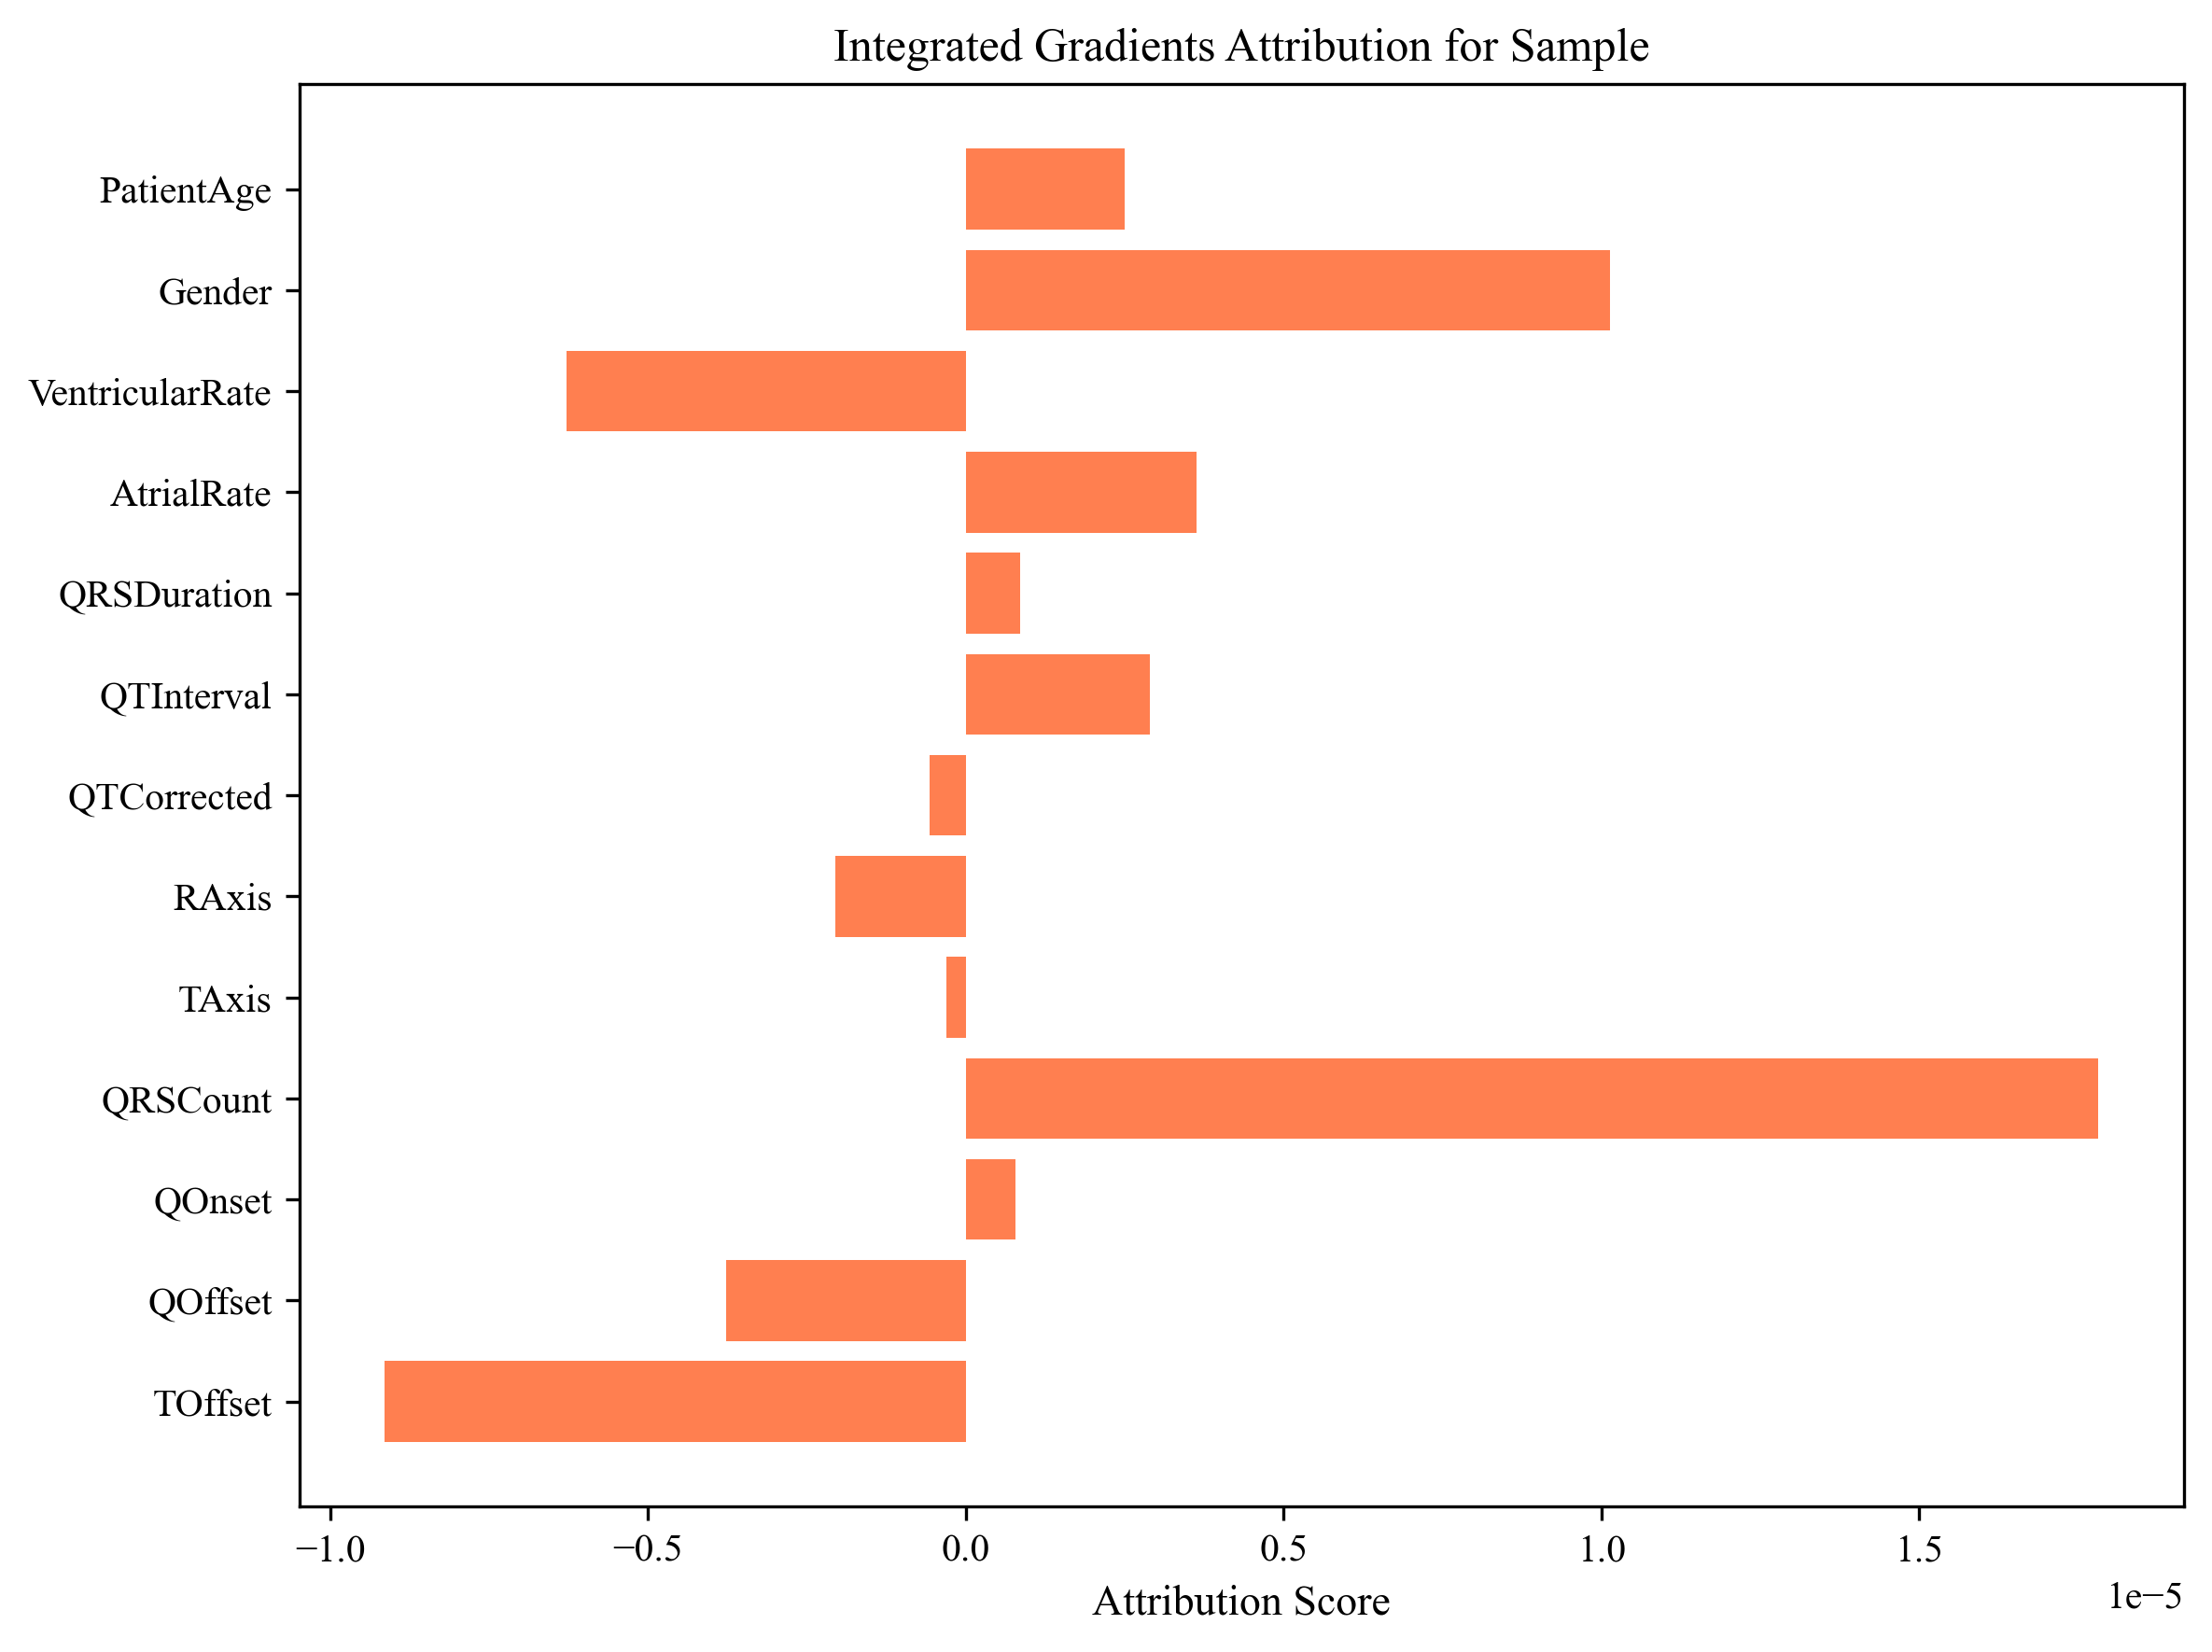

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Set global font
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Define the Integrated Gradients function manually
@tf.function
def interpolate_inputs(baseline, input, alphas):
    alphas_x = alphas[:, tf.newaxis]
    delta = input - baseline
    inputs = baseline + alphas_x * delta
    return inputs

def compute_gradients(inputs, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = final_model(inputs)
        target_class_scores = predictions[:, target_class_idx]
    return tape.gradient(target_class_scores, inputs)

def integrated_gradients(input, baseline=None, target_class_idx=1, m_steps=50, batch_size=32):
    if baseline is None:
        baseline = tf.zeros(shape=input.shape)
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)
    interpolated_inputs = interpolate_inputs(baseline, input, alphas)
    gradients = []
    for i in range(0, m_steps, batch_size):
        batch = interpolated_inputs[i:i+batch_size]
        grads = compute_gradients(batch, target_class_idx)
        gradients.append(grads)
    total_gradients = tf.reduce_mean(tf.concat(gradients, axis=0), axis=0)
    integrated_grads = (input - baseline) * total_gradients
    return integrated_grads

# Choose a sample input from the validation set
x_sample = tf.convert_to_tensor(X_val[10:11], dtype=tf.float32)

# Compute IG attributions
ig_attributions = integrated_gradients(x_sample, target_class_idx=1).numpy().flatten()

# Feature names (from original dataset)
feature_names = ['PatientAge', 'Gender', 'VentricularRate', 'AtrialRate', 'QRSDuration',
                 'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QRSCount',
                 'QOnset', 'QOffset', 'TOffset']

# Plot attributions
plt.figure(figsize=(8, 6), dpi=300)
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, ig_attributions, align='center', color='coral')
plt.yticks(y_pos, feature_names)
plt.xlabel('Attribution Score', fontsize=11)
plt.title('Integrated Gradients Attribution for Sample', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("integrated_gradients_custom_output.png", dpi=300)
plt.show()
